# Método DiSCaGe - Implementação

## Library Import

In [7]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations

## Table 1. MAF file for the running example.

In [9]:
maf_path = './inputs/maf_file.maf'

try:
    maf_df = pd.read_csv(maf_path, sep='\t', comment='#')
    print(maf_df.head())
except Exception as e:
    print(f"Erro ao ler o arquivo MAF: {e}")

  Hugo_Symbol  Chromosome  Start_Position  End_Position Strand  \
0          G1           7          100000        100000      +   
1          G1           7          100000        100000      +   
2          G1           7          100000        100001      +   
3          G1           7          100000        100000      +   
4          G1           7          100000        100000      +   

   Variant_Classification Variant_Type Reference_Allele Tumor_Seq_Allele1  \
0       Missense_Mutation          SNP                A                 A   
1       Nonsense_Mutation          SNP                G                 G   
2         Frame_Shift_Ins          INS                -                 -   
3         Frame_Shift_Del          DEL                C                 C   
4  Translation_Start_Site          SNP                A                 A   

  Tumor_Seq_Allele2 Tumor_Sample_Barcode  
0                 T                   P3  
1                 C                   P3  
2          

## Table 2. Mutation weights.

In [10]:
mutation_weights = {
    'Nonsense_Mutation': 1.0,
    'Missense_Mutation': 0.4,
    'Splice_Site': 0.4,
    'Frame_Shift_Del': 1.0,
    'Frame_Shift_Ins': 1.0,
    'In_Frame_Del': 0.4,
    'In_Frame_Ins': 0.4,
    '3\'UTR': 0.2,
    '5\'UTR': 0.4,
    'Nonstop_Mutation': 0.4,
    'Translation_Start_Site': 0.2
}

## Step 1- Weighted Mutation Matrix (WMM)

In [11]:
maf_df['Weight'] = maf_df['Variant_Classification'].map(mutation_weights)

wmm = maf_df.groupby(['Tumor_Sample_Barcode', 'Hugo_Symbol'])['Weight'].mean().unstack(fill_value=0)

print(wmm)

Hugo_Symbol             G1  G10  G11   G2   G3   G4   G5   G6   G7   G8
Tumor_Sample_Barcode                                                   
P1                    0.00  0.6  0.0  0.0  0.0  0.0  0.0  0.5  0.0  0.0
P2                    0.00  0.0  0.6  0.6  1.0  0.0  0.4  0.0  0.0  0.0
P3                    0.72  0.4  0.0  0.0  0.6  0.6  0.0  0.4  0.6  0.0
P4                    0.40  0.0  0.0  0.6  0.0  0.4  0.0  0.0  0.0  0.0
P5                    0.00  0.0  0.0  0.4  0.4  0.4  0.0  0.0  1.0  0.8
P6                    0.00  0.6  0.0  0.0  0.0  0.0  0.0  0.0  0.6  0.0


## Step 2 - Weighted frequencies

In [12]:
def calculate_normalized_gene_scores(maf_df, wmm):

    numero_pacientes = maf_df['Tumor_Sample_Barcode'].nunique()
    pontuacao_bruta_genes = wmm.sum(axis=0) / numero_pacientes
    pontuacao_normalizada_genes = pontuacao_bruta_genes / pontuacao_bruta_genes.max()

    pontuacoes_df = pd.DataFrame({
        'wf': pontuacao_bruta_genes,
        'nwf': pontuacao_normalizada_genes
    }).reset_index()

    if 'index' in pontuacoes_df.columns:
        pontuacoes_df.rename(columns={'index': 'Gene'}, inplace=True)
    elif 'Hugo_Symbol' in pontuacoes_df.columns:
        pontuacoes_df.rename(columns={'Hugo_Symbol': 'Gene'}, inplace=True)
    else:
        print("Coluna não encontrada.")

    pontuacoes_df.sort_values(by='Gene', inplace=True)
    pontuacoes_df.reset_index(drop=True, inplace=True)

    return pontuacoes_df, pontuacoes_df['nwf']

pontuacoes_df, nwf = calculate_normalized_gene_scores(maf_df, wmm)
print(pontuacoes_df)

  Gene        wf       nwf
0   G1  0.186667  0.509091
1  G10  0.266667  0.727273
2  G11  0.100000  0.272727
3   G2  0.266667  0.727273
4   G3  0.333333  0.909091
5   G4  0.233333  0.636364
6   G5  0.066667  0.181818
7   G6  0.150000  0.409091
8   G7  0.366667  1.000000
9   G8  0.133333  0.363636


## Step 3 - Consensus Network UGN

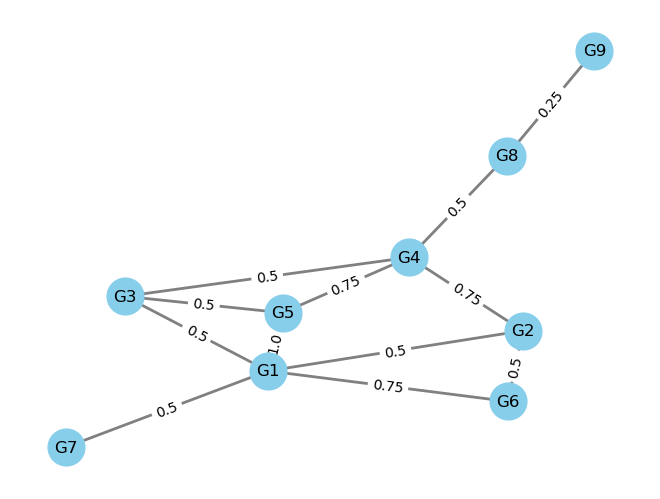

('G1', 'G2', {'weight': 0.5})
('G1', 'G3', {'weight': 0.5})
('G1', 'G5', {'weight': 1.0})
('G1', 'G6', {'weight': 0.75})
('G1', 'G7', {'weight': 0.5})
('G2', 'G4', {'weight': 0.75})
('G2', 'G6', {'weight': 0.5})
('G3', 'G4', {'weight': 0.5})
('G3', 'G5', {'weight': 0.5})
('G5', 'G4', {'weight': 0.75})
('G4', 'G8', {'weight': 0.5})
('G8', 'G9', {'weight': 0.25})


In [14]:
def calculate_frequency_pairs(file_paths):
    
    exact_pair_frequency = defaultdict(int)

    for file_path in file_paths:
        with open(file_path, 'r') as file:
            for line in file:
                genes = line.strip().split()

                for i in range(len(genes) - 1):
                    pair = f"{genes[i]} {genes[i+1]}"
                    exact_pair_frequency[pair] += 1

    unordered_pair_frequency = defaultdict(int)
    for pair, freq in exact_pair_frequency.items():
        genes = pair.split()
        unordered_pair = tuple(sorted(genes))
        unordered_pair_frequency[unordered_pair] += freq

    total_files = len(file_paths)
    for pair in unordered_pair_frequency:
        unordered_pair_frequency[pair] = unordered_pair_frequency[pair] / total_files

    return unordered_pair_frequency

def create_graph(unordered_pair_frequency):
    
    G = nx.Graph()

    for pair, freq in unordered_pair_frequency.items():
        gene1, gene2 = pair
        G.add_edge(gene1, gene2, weight=freq)

    return G

def display_graph(G):
    
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=700, edge_color='gray', width=2)
    edge_weights = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights)
    plt.show()

file_paths = ['./inputs/GeneNetwork_1.txt',
                 './inputs/GeneNetwork_2.txt',
                 './inputs/GeneNetwork_3.txt',
                 './inputs/GeneNetwork_4.txt'
             ]

unordered_pair_frequency = calculate_frequency_pairs(file_paths)
ugn = create_graph(unordered_pair_frequency)
display_graph(ugn)

edges_with_weights = ugn.edges(data=True)
for edge in edges_with_weights:
    print(edge)

## Step 4 - Gene Strength Spreading Network GSSN

In [15]:
def build_gssn(gene_network):
    
    gssn = nx.DiGraph()
    gene_network.remove_edges_from(nx.selfloop_edges(gene_network))
    
    max_weight = 0
    for g_i, g_j in gene_network.edges:
        weight_ij = gene_network[g_i][g_j]["weight"]
        r_i = sum(gene_network[g_i][neighbor]['weight'] for neighbor in gene_network[g_i])
        r_j = sum(gene_network[g_j][neighbor]['weight'] for neighbor in gene_network[g_j])
        r_i_out = sum(gene_network[g_i][neighbor]['weight'] for neighbor in set(gene_network[g_i]) - set(gene_network[g_j]) - {g_j})
        r_j_out = sum(gene_network[g_j][neighbor]['weight'] for neighbor in set(gene_network[g_j]) - set(gene_network[g_i]) - {g_i})

        s_ij = (1 + (r_i * r_j_out)) * weight_ij
        s_ji = (1 + (r_j * r_i_out)) * weight_ij

        gssn.add_edge(g_i, g_j, weight=s_ij)
        gssn.add_edge(g_j, g_i, weight=s_ji)

        max_weight = max(max_weight, s_ij, s_ji)

    for _, _, d in gssn.edges(data=True):
        d['weight'] /= max_weight

    return gssn, max_weight

gssn, max_weight = build_gssn(ugn)
print("Max weight:", max_weight)
for edge in gssn.edges(data=True):
    print(edge)

Max weight: 4.9375
('G1', 'G2', {'weight': 0.34810126582278483})
('G1', 'G3', {'weight': 0.26582278481012656})
('G1', 'G5', {'weight': 0.6962025316455697})
('G1', 'G6', {'weight': 0.1518987341772152})
('G1', 'G7', {'weight': 0.10126582278481013})
('G2', 'G1', {'weight': 0.45569620253164556})
('G2', 'G4', {'weight': 0.6170886075949367})
('G2', 'G6', {'weight': 0.10126582278481013})
('G3', 'G1', {'weight': 0.3670886075949367})
('G3', 'G4', {'weight': 0.2911392405063291})
('G3', 'G5', {'weight': 0.10126582278481013})
('G5', 'G1', {'weight': 1.0})
('G5', 'G3', {'weight': 0.10126582278481013})
('G5', 'G4', {'weight': 0.5791139240506329})
('G6', 'G1', {'weight': 0.5316455696202531})
('G6', 'G2', {'weight': 0.1962025316455696})
('G7', 'G1', {'weight': 0.24050632911392406})
('G4', 'G2', {'weight': 0.5316455696202531})
('G4', 'G3', {'weight': 0.22784810126582278})
('G4', 'G5', {'weight': 0.5316455696202531})
('G4', 'G8', {'weight': 0.16455696202531644})
('G8', 'G4', {'weight': 0.253164556962025

## Step 5 - Neighbors mutation influence

In [16]:
def calculate_neighbors_mutation_influence(gssn, nwf, max_weight):
    data = []
    r_values = {}

    if not all(node in nwf.index for node in gssn.nodes):
        print("Os identificadores dos nós não estão alinhados com os índices em nwf.")
        return pd.DataFrame(data)

    for gene in gssn.nodes():
        r = sum(nwf[neighbor] * gssn[gene][neighbor]['weight'] for neighbor in gssn.successors(gene))
        r_values[gene] = r

    max_r = max(r_values.values(), default=1)

    for gene, r in r_values.items():
        nr = r / max_r if max_r > 0 else 0
        data.append({'Gene': gene, 'r': r, 'nr': nr})

    influence_df = pd.DataFrame(data)
    return influence_df

nwf.index = ['G' + str(i) for i in range(1, len(nwf) + 1)]
influence_df = calculate_neighbors_mutation_influence(gssn, nwf, max_weight)

print(influence_df)

  Gene         r        nr
0   G1  1.073648  1.000000
1   G2  0.745224  0.694105
2   G3  0.490679  0.457020
3   G5  0.957883  0.892176
4   G6  0.413349  0.384995
5   G7  0.122440  0.114041
6   G4  0.999425  0.930868
7   G8  0.234753  0.218650
8   G9  0.023303  0.021704


## Step 6 - Final mutation score

In [17]:
def generate_final_mutation_score_table(nwf, influence_df):

    data = []
    for index, row in influence_df.iterrows():
        gene = row['Gene']
        mutation_score = nwf.get(gene, 0)
        neighbors_influence_score = row['nr']
        final_mutation_score = mutation_score + neighbors_influence_score
        data.append({
            'Gene': gene, 
            'nwf': mutation_score, 
            'r': neighbors_influence_score, 
            'ms': final_mutation_score
        })
    final_scores_df = pd.DataFrame(data)
    
    final_scores_df = final_scores_df.sort_values(by='ms', ascending=False)

    return final_scores_df

final_mutation_scores_table = generate_final_mutation_score_table(nwf, influence_df)
print(final_mutation_scores_table)

  Gene       nwf         r        ms
3   G5  0.909091  0.892176  1.801267
6   G4  0.727273  0.930868  1.658141
0   G1  0.509091  1.000000  1.509091
1   G2  0.727273  0.694105  1.421378
8   G9  1.000000  0.021704  1.021704
4   G6  0.636364  0.384995  1.021358
2   G3  0.272727  0.457020  0.729748
7   G8  0.409091  0.218650  0.627740
5   G7  0.181818  0.114041  0.295859
